Jumlah keypoint terdeteksi: 4776


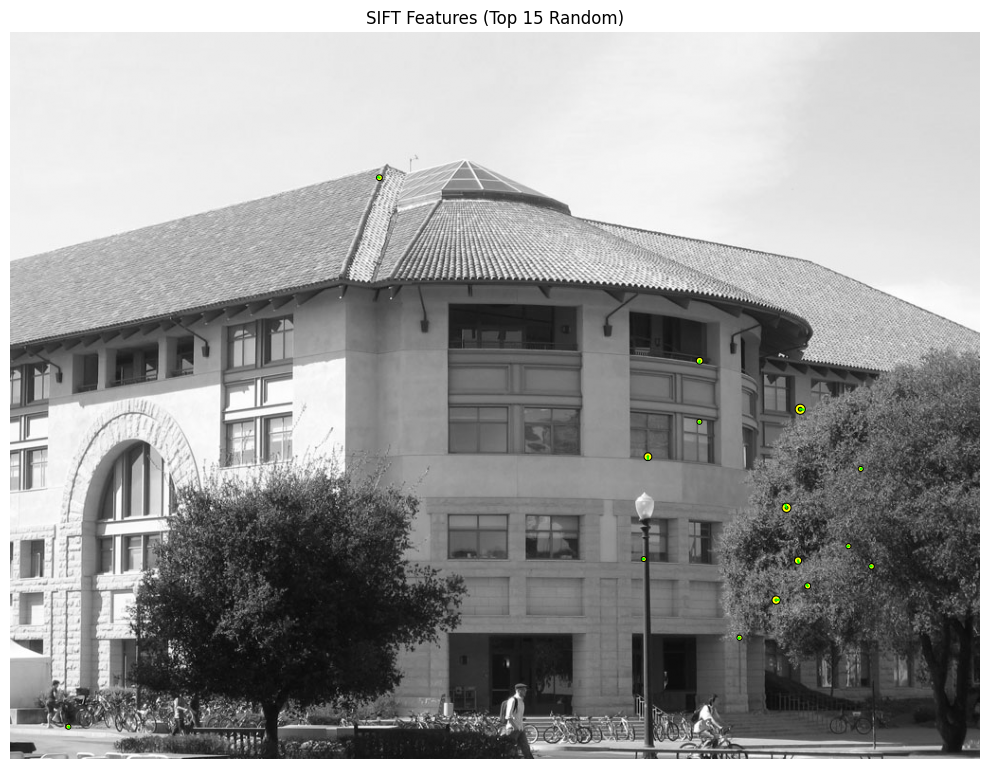

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

def draw_sift_features(img, keypoints, ax):
    """
    Fungsi custom untuk meniru gaya visualisasi vl_plotframe & vl_plotsiftdescriptor.
    Menggambar lingkaran (Frame) dan Garis Orientasi (Descriptor representation).
    """
    for kp in keypoints:
        x, y = kp.pt
        # kp.size di OpenCV adalah diameter. Radius = size / 2.
        radius = kp.size / 2
        angle_deg = kp.angle
        angle_rad = np.deg2rad(angle_deg)
        
        # 1. Gambar Frame (Lingkaran)
        # Meniru: h1 (hitam tebal) dan h2 (kuning tipis)
        # Kita pakai Edge hitam tebal, Face kosong
        circle_outline = patches.Circle((x, y), radius, linewidth=3, 
                                        edgecolor='black', facecolor='none')
        ax.add_patch(circle_outline)
        
        # Lingkaran kuning tipis di dalamnya
        circle_inner = patches.Circle((x, y), radius, linewidth=1.5, 
                                      edgecolor='yellow', facecolor='none')
        ax.add_patch(circle_inner)
        
        # 2. Gambar Orientasi (Descriptor)
        # Meniru: h3 (hijau)
        # Menghitung ujung garis berdasarkan sudut dan radius
        # SIFT descriptor grid sulit direplikasi manual, kita gunakan orientasi utama
        end_x = x + radius * np.cos(angle_rad)
        end_y = y + radius * np.sin(angle_rad)
        
        ax.plot([x, end_x], [y, end_y], color='lime', linewidth=1.5)

def run_sift_descriptor():
    filename = 'gates.jpg'
    
    # --- Buat Dummy Image jika file tidak ada ---
    if not os.path.exists(filename):
        print(f"File '{filename}' tidak ditemukan. Membuat gambar dummy...")
        img = np.zeros((512, 512, 3), dtype=np.uint8)
        # Gambar kotak-kotak agar ada fitur sudut untuk SIFT
        for r in range(0, 512, 50):
            for c in range(0, 512, 50):
                if (r+c) % 100 == 0:
                    cv2.rectangle(img, (c, r), (c+50, r+50), (200, 200, 200), -1)
        # Tambah lingkaran
        cv2.circle(img, (256, 256), 100, (255, 255, 255), 5)
    else:
        img = cv2.imread(filename)

    # Convert ke Grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. Extract SIFT Features
    # MATLAB: vl_sift(img, 'PeakThresh', 5) (Scale 0-255)
    # OpenCV: contrastThreshold (Scale 0-1). 5/255 ~= 0.02
    
    # Inisialisasi SIFT
    sift = cv2.SIFT_create(contrastThreshold=0.03, edgeThreshold=10)
    
    # Detect & Compute
    # keypoints (f di matlab), descriptors (d di matlab)
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)
    
    print(f"Jumlah keypoint terdeteksi: {len(keypoints)}")
    
    # 2. Select Random Subset
    num_display = 15
    if len(keypoints) > num_display:
        # Random choice tanpa replacement
        selected_kps = np.random.choice(keypoints, num_display, replace=False)
    else:
        selected_kps = keypoints

    # 3. Visualize Descriptors
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Tampilkan gambar background grayscale
    ax.imshow(img_gray, cmap='gray')
    ax.set_title(f'SIFT Features (Top {num_display} Random)')
    ax.axis('off')

    # Panggil fungsi gambar custom
    draw_sift_features(img, selected_kps, ax)
    
    # SIFT descriptor geometry visualization (grid 4x4)
    # Sangat sulit direplikasi 100% di Python tanpa kode native yang panjang.
    # Visualisasi "Circle + Orientation Line" di atas adalah standar de facto
    # untuk "Rich Keypoints" di OpenCV Python.
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_sift_descriptor()

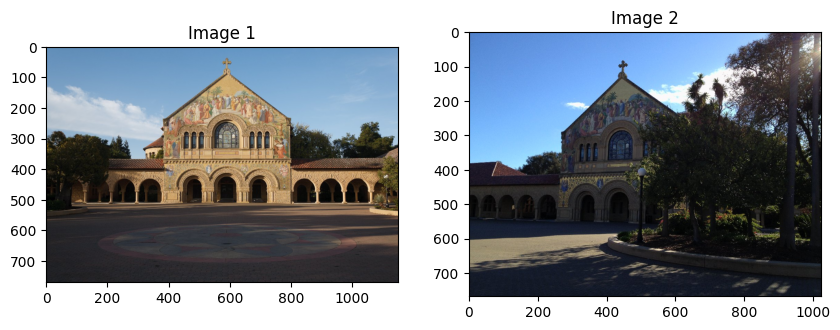

Running SIFT Mosaic...
Keypoints Image 1: 3057
Keypoints Image 2: 2259
Good matches found: 84


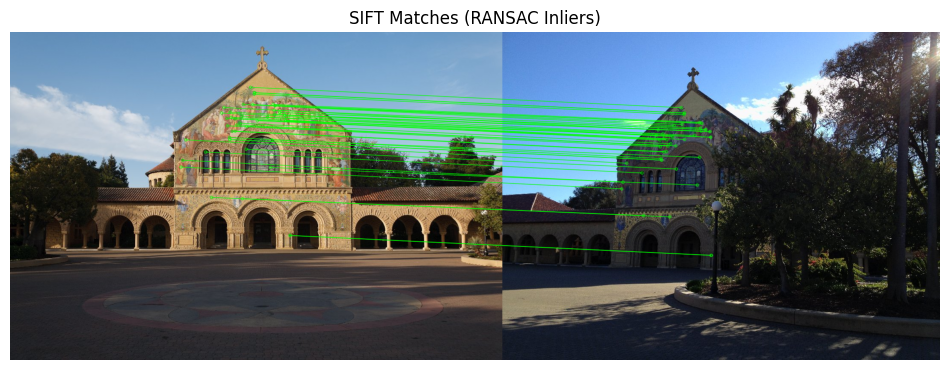

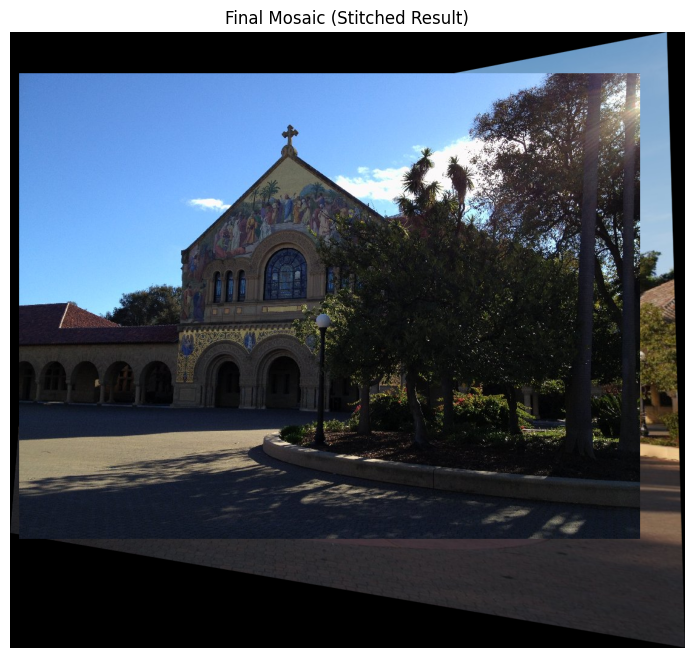

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def sift_mosaic(img1, img2):

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    print(f"Keypoints Image 1: {len(kp1)}")
    print(f"Keypoints Image 2: {len(kp2)}")


    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            
    print(f"Good matches found: {len(good_matches)}")


    if len(good_matches) > 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)


        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        matches_mask = mask.ravel().tolist()
        
        draw_params = dict(matchColor=(0, 255, 0),
                           singlePointColor=None,
                           matchesMask=matches_mask, 
                           flags=2)
        
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        plt.title('SIFT Matches (RANSAC Inliers)')
        plt.axis('off')
        plt.show()

        h1, w1 = img1.shape[:2]
        h2, w2 = img2.shape[:2]
        

        pts = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, H)
        
        pts2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)
        all_pts = np.concatenate((dst, pts2), axis=0)
        
        [xmin, ymin] = np.int32(all_pts.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(all_pts.max(axis=0).ravel() + 0.5)
        
        translation_dist = [-xmin, -ymin]
        H_translation = np.array([[1, 0, translation_dist[0]], 
                                  [0, 1, translation_dist[1]], 
                                  [0, 0, 1]])
        
        warped_img = cv2.warpPerspective(img1, H_translation.dot(H), (xmax-xmin, ymax-ymin))
        
        y_offset = translation_dist[1]
        x_offset = translation_dist[0]
        

        warped_img[y_offset:y_offset+h2, x_offset:x_offset+w2] = img2

        return warped_img

    else:
        print("Not enough matches are found - {}/{}".format(len(good_matches), 4))
        return None

def run_ransac_mosaic():
    filename1 = 'church1.jpg'
    filename2 = 'church2.jpg'

    if not os.path.exists(filename1):
        print("File gambar tidak ditemukan. Membuat gambar simulasi...")
        base = np.zeros((600, 800, 3), dtype=np.uint8)
        for i in range(100):
            cv2.circle(base, (np.random.randint(0,800), np.random.randint(0,600)), 
                       np.random.randint(10,50), np.random.randint(0,255,3).tolist(), -1)
        cv2.putText(base, "SIFT RANSAC", (200, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        
        img1_sim = base[:, :500, :]
        cv2.imwrite(filename1, img1_sim)
        
        img2_raw = base[:, 300:, :]
        rows, cols, ch = img2_raw.shape
        pts1 = np.float32([[0,0], [cols,0], [0,rows], [cols,rows]])
        pts2 = np.float32([[0,0], [cols,20], [20,rows], [cols-20,rows-20]]) 
        M = cv2.getPerspectiveTransform(pts1, pts2)
        img2_sim = cv2.warpPerspective(img2_raw, M, (cols, rows))
        cv2.imwrite(filename2, img2_sim)

    img1 = cv2.imread(filename1)
    img2 = cv2.imread(filename2)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)); plt.title('Image 1')
    plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.title('Image 2')
    plt.show()

    print("Running SIFT Mosaic...")
    

    mosaic_res = sift_mosaic(img1, img2)
    
    if mosaic_res is not None:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(mosaic_res, cv2.COLOR_BGR2RGB))
        plt.title('Final Mosaic (Stitched Result)')
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    run_ransac_mosaic()